# Modello per la predizione delle emozioni da immagini di espressioni facciali

## Data retrival

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/AIExam/data.zip /content
!pip install contractions emoji ekphrasis --quiet
!unzip data.zip

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import pandas as pd
import csv
from PIL import Image
import re
import numpy as np
import contractions, emoji
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

EPOCH = 100

In [ ]:
def load_data(file_path):
    data = []
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader, None)
        for row in csv_reader:
            text, image_path, emotion = row
            img = Image.open(image_path)
            img_array = np.array(img)
            entry = {'text': text, 'image_data': img_array, 'emotion': emotion}
            data.append(entry)
    return data

file_path = "data/processed/text_image_emotion.csv"
data = load_data(file_path)


Dati con indice 321


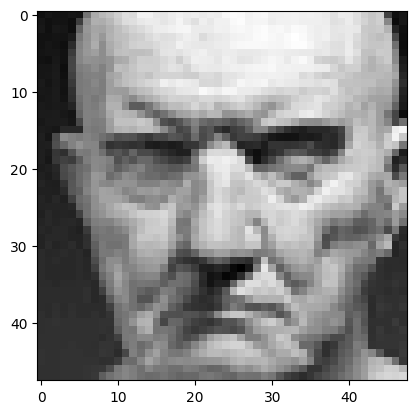

Emozione: anger

Dati con indice 4321


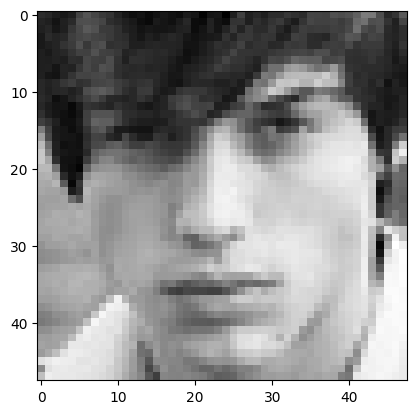

Emozione: neutral


In [ ]:
images = np.array([entry['image_data'] for entry in data])
emotions = [entry['emotion'] for entry in data]

def show_data(i):
  print("\nDati con indice", i)
  plt.imshow(images[i],cmap = plt.cm.gray)
  plt.show()
  print("Emozione:", emotions[i])

show_data(321)

i = 4321
show_data(i)

## Encoding delle emozioni

In [ ]:
label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(emotions)
categorical_emotions = tf.keras.utils.to_categorical(encoded_emotions, num_classes=len(label_encoder.classes_))

custom_p = lambda n: print("emotion\t ", n, "  \tis encoded with the number\t", encoded_emotions[emotions.index(n)], "\tand vector\t", categorical_emotions[emotions.index(n)])

custom_p("anger")
custom_p("disgust")
custom_p("fear")
custom_p("joy")
custom_p("neutral")
custom_p("sadness")
custom_p("surprise")

emotion	  anger   	is encoded with the number	 0 	and vector	 [1. 0. 0. 0. 0. 0. 0.]
emotion	  disgust   	is encoded with the number	 1 	and vector	 [0. 1. 0. 0. 0. 0. 0.]
emotion	  fear   	is encoded with the number	 2 	and vector	 [0. 0. 1. 0. 0. 0. 0.]
emotion	  joy   	is encoded with the number	 3 	and vector	 [0. 0. 0. 1. 0. 0. 0.]
emotion	  neutral   	is encoded with the number	 4 	and vector	 [0. 0. 0. 0. 1. 0. 0.]
emotion	  sadness   	is encoded with the number	 5 	and vector	 [0. 0. 0. 0. 0. 1. 0.]
emotion	  surprise   	is encoded with the number	 6 	and vector	 [0. 0. 0. 0. 0. 0. 1.]


## Creazione del dataset
Dividiamo il dataset nella seguente maniera:
*   train data: 80%  
*   validation data: 10%  
*   test data: 10%  

In [ ]:
image_train, image_test_temp, emotion_train, emotion_test_temp = train_test_split(
    images, categorical_emotions, test_size=0.2, random_state=42
)

image_test, image_val, emotion_test, emotion_val = train_test_split(
    image_test_temp, emotion_test_temp, test_size=0.5, random_state=42
)

print("Lunghezza dati di train:", len(image_train))
print("Lunghezza dati di validation:", len(image_val))
print("Lunghezza dati di test:", len(image_test))

Lunghezza dati di train: 20402
Lunghezza dati di validation: 2551
Lunghezza dati di test: 2550


## Prima prova

In [ ]:
# seconda parte
image_input = layers.Input(shape=(48, 48))
image_dense_layer = layers.Dense(64, activation='relu')(image_input)
image_flatten = layers.Flatten()(image_dense_layer)

dropout_layer = layers.Dropout(0.5)(image_flatten)
dense_layer = layers.Dense(64, activation='relu')(image_input)
output_layer = layers.Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)

model = models.Model(inputs=image_input, outputs=output_layer)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
model.summary()

checkpoint_callback = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 48, 48)]          0         
                                                                 
 dense_9 (Dense)             (None, 48, 64)            3136      
                                                                 
 flatten_7 (Flatten)         (None, 3072)              0         
                                                                 
 dropout_7 (Dropout)         (None, 3072)              0         
                                                                 
 dense_11 (Dense)            (None, 7)                 21511     
                                                                 
Total params: 24647 (96.28 KB)
Trainable params: 24647 (96.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(image_train, emotion_train, epochs=EPOCH, validation_data=(image_val, emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate(image_test, emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
638/638 [==============================] - 5s 6ms/step - loss: 1.6316 - accuracy: 0.3555 - precision_5: 0.5658 - recall_5: 0.0447 - val_loss: 1.5502 - val_accuracy: 0.4136 - val_precision_5: 0.6637 - val_recall_5: 0.1152
Epoch 2/100
638/638 [==============================] - 4s 6ms/step - loss: 1.5517 - accuracy: 0.4039 - precision_5: 0.6028 - recall_5: 0.1003 - val_loss: 1.5190 - val_accuracy: 0.4371 - val_precision_5: 0.6926 - val_recall_5: 0.0804
Epoch 3/100
638/638 [==============================] - 3s 4ms/step - loss: 1.5221 - accuracy: 0.4181 - precision_5: 0.6087 - recall_5: 0.1235 - val_loss: 1.4877 - val_accuracy: 0.4563 - val_precision_5: 0.6957 - val_recall_5: 0.1317
Epoch 4/100
638/638 [==============================] - 3s 5ms/step - loss: 1.4994 - accuracy: 0.4284 - precision_5: 0.6211 - recall_5: 0.1399 - val_loss: 1.4759 - val_accuracy: 0.4618 - val_precision_5: 0.6901 - val_recall_5: 0.1388
Epoch 5/100
638/638 [==============================] - 3s 5ms/step -

Loss: 1.44, Accuracy: 0.47, Precision: 0.62, Recall: 0.23.

## Seconda prova

In [ ]:
print("Image", images[i])
norm_images = images / 255
print("\nNormalized image", norm_images[i])

image_train, image_test_temp, emotion_train, emotion_test_temp = train_test_split(
    norm_images, categorical_emotions, test_size=0.2, random_state=42
)

image_test, image_val, emotion_test, emotion_val = train_test_split(
    image_test_temp, emotion_test_temp, test_size=0.5, random_state=42
)

Image [[ 44  39  28 ...  41  53  89]
 [ 37  31  19 ...  51  32  68]
 [ 32  38  23 ...  42  34  46]
 ...
 [223 232 240 ... 246 246 236]
 [139 224 233 ... 246 243 234]
 [191 238 233 ... 243 238 234]]

Normalized image [[0.17254902 0.15294118 0.10980392 ... 0.16078431 0.20784314 0.34901961]
 [0.14509804 0.12156863 0.0745098  ... 0.2        0.1254902  0.26666667]
 [0.1254902  0.14901961 0.09019608 ... 0.16470588 0.13333333 0.18039216]
 ...
 [0.8745098  0.90980392 0.94117647 ... 0.96470588 0.96470588 0.9254902 ]
 [0.54509804 0.87843137 0.91372549 ... 0.96470588 0.95294118 0.91764706]
 [0.74901961 0.93333333 0.91372549 ... 0.95294118 0.93333333 0.91764706]]


In [ ]:
model.fit(image_train, emotion_train, epochs=EPOCH, validation_data=(image_val, emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate(image_test, emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
638/638 [==============================] - 4s 5ms/step - loss: 1.6430 - accuracy: 0.3451 - precision_6: 0.5668 - recall_6: 0.0374 - val_loss: 1.5667 - val_accuracy: 0.4132 - val_precision_6: 0.6713 - val_recall_6: 0.0568
Epoch 2/100
638/638 [==============================] - 3s 4ms/step - loss: 1.5559 - accuracy: 0.3987 - precision_6: 0.6135 - recall_6: 0.0942 - val_loss: 1.5158 - val_accuracy: 0.4289 - val_precision_6: 0.6652 - val_recall_6: 0.1192
Epoch 3/100
638/638 [==============================] - 4s 6ms/step - loss: 1.5212 - accuracy: 0.4179 - precision_6: 0.6162 - recall_6: 0.1223 - val_loss: 1.4950 - val_accuracy: 0.4477 - val_precision_6: 0.6906 - val_recall_6: 0.1094
Epoch 4/100
638/638 [==============================] - 3s 4ms/step - loss: 1.5024 - accuracy: 0.4264 - precision_6: 0.6194 - recall_6: 0.1378 - val_loss: 1.4920 - val_accuracy: 0.4488 - val_precision_6: 0.6350 - val_recall_6: 0.1678
Epoch 5/100
638/638 [==============================] - 3s 4ms/step -

Loss: 1.41, Accuracy: 0.48, Precision: 0.66, Recall: 0.22.

## Terza prova

In [ ]:
image_input = layers.Input(shape=(48, 48, 1))
conv_layer = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
pooling_layer = layers.MaxPooling2D((2, 2))(conv_layer)
image_flatten = layers.Flatten()(pooling_layer)

dropout_layer = layers.Dropout(0.5)(image_flatten)
output_layer = layers.Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)

optimizer = Adam(learning_rate=0.001)
model = models.Model(inputs=image_input, outputs=output_layer)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
model.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_18 (Flatten)        (None, 16928)             0         
                                                                 
 dropout_18 (Dropout)        (None, 16928)             0         
                                                                 
 dense_22 (Dense)            (None, 7)                 118503    
                                                          

In [ ]:
model.fit(image_train, emotion_train, epochs=EPOCH, validation_data=(image_val, emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate(image_test, emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
638/638 [==============================] - 5s 7ms/step - loss: 1.5613 - accuracy: 0.3988 - precision_15: 0.6883 - recall_15: 0.0753 - val_loss: 1.4432 - val_accuracy: 0.4802 - val_precision_15: 0.7809 - val_recall_15: 0.1313
Epoch 2/100
638/638 [==============================] - 3s 4ms/step - loss: 1.3971 - accuracy: 0.4815 - precision_15: 0.7004 - recall_15: 0.2092 - val_loss: 1.3576 - val_accuracy: 0.5080 - val_precision_15: 0.7240 - val_recall_15: 0.2376
Epoch 3/100
638/638 [==============================] - 3s 4ms/step - loss: 1.3260 - accuracy: 0.5091 - precision_15: 0.7157 - recall_15: 0.2649 - val_loss: 1.3745 - val_accuracy: 0.5182 - val_precision_15: 0.6754 - val_recall_15: 0.2920
Epoch 4/100
638/638 [==============================] - 3s 5ms/step - loss: 1.2806 - accuracy: 0.5271 - precision_15: 0.7124 - recall_15: 0.2973 - val_loss: 1.3080 - val_accuracy: 0.5292 - val_precision_15: 0.7356 - val_recall_15: 0.2913
Epoch 5/100
638/638 [==============================]

Loss: 1.27, Accuracy: 0.54, Precision: 0.68, Recall: 0.38.

## Quarta prova

In [ ]:
image_input = layers.Input(shape=(48, 48, 1))
conv_layer = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
pooling_layer1 = layers.MaxPooling2D((2, 2))(conv_layer)
conv_layer2 = layers.Conv2D(24, (3, 3), activation='relu')(pooling_layer1)
pooling_layer2 = layers.MaxPooling2D((2, 2))(conv_layer2)
image_flatten = layers.Flatten()(pooling_layer2)

dropout_layer = layers.Dropout(0.5)(image_flatten)
output_layer = layers.Dense(len(label_encoder.classes_), activation='softmax')(dropout_layer)

optimizer = Adam(learning_rate=0.001)
model = models.Model(inputs=image_input, outputs=output_layer)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 21, 21, 24)        6936      
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 10, 10, 24)        0         
 ng2D)                                                           
                                                                 
 flatten_17 (Flatten)        (None, 2400)              0  

In [ ]:
model.fit(image_train, emotion_train, epochs=EPOCH, validation_data=(image_val, emotion_val), callbacks=[checkpoint_callback, early_stopping_callback])

evaluation_results = model.evaluate(image_test, emotion_test)
print(f"Loss: {round(evaluation_results[0], 2)}, Accuracy: {round(evaluation_results[1], 2)}")

Epoch 1/100
638/638 [==============================] - 5s 5ms/step - loss: 1.5979 - accuracy: 0.3722 - precision_13: 0.6306 - recall_13: 0.0541 - val_loss: 1.4567 - val_accuracy: 0.4751 - val_precision_13: 0.7484 - val_recall_13: 0.1399
Epoch 2/100
638/638 [==============================] - 3s 5ms/step - loss: 1.4309 - accuracy: 0.4676 - precision_13: 0.6981 - recall_13: 0.1874 - val_loss: 1.3399 - val_accuracy: 0.5237 - val_precision_13: 0.7503 - val_recall_13: 0.2368
Epoch 3/100
638/638 [==============================] - 3s 5ms/step - loss: 1.3404 - accuracy: 0.5066 - precision_13: 0.7127 - recall_13: 0.2676 - val_loss: 1.3119 - val_accuracy: 0.5327 - val_precision_13: 0.7834 - val_recall_13: 0.2297
Epoch 4/100
638/638 [==============================] - 4s 6ms/step - loss: 1.2972 - accuracy: 0.5229 - precision_13: 0.7148 - recall_13: 0.2961 - val_loss: 1.2403 - val_accuracy: 0.5547 - val_precision_13: 0.7434 - val_recall_13: 0.3293
Epoch 5/100
638/638 [==============================]

Loss: 1.06, Accuracy: 0.61, Precision: 0.76, Recall: 0.45.